# MCMC: Metropolis-Hastings algorithm and diagnostics

Florent Leclercq,<br/>
Imperial Centre for Inference and Cosmology, Imperial College London,<br/>
florent.leclercq@polytechnique.org

In [1]:
import numpy as np
from scipy.stats import norm, binom, beta
from matplotlib import pyplot as plt
from cycler import cycler
np.random.seed(123456)
%matplotlib inline
plt.rcParams.update({'lines.linewidth': 2})

In this notebook we consider a Bernoulli experiment (a series of $N_{\mathrm{trials}}$ independent experiments, each with its own boolean-valued outcome). The target parameter is the success rate $\theta$. The likelihood for this problem is a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) and the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) provides a family of conjuguate priors for Bayesian inference.

## Generate data

In [2]:
groundtruth = 0.38
Ntrials = 100
Nsuccesses = binom(Ntrials, groundtruth).rvs()
Nsuccesses

33

## Analytic solution

If the likelihood is a binomial distribution with $N_{\mathrm{successes}}$ for $N_{\mathrm{trials}}$, and if the prior is a beta distribution with parameters ($\alpha$, $\beta$), then the posterior is a beta distribution with parameters
\begin{equation}
\alpha' = \alpha+N_{\mathrm{successes}}, \quad \beta' = \beta + N_{\mathrm{trials}} - N_{\mathrm{successes}}
\end{equation}
(see for example https://en.wikipedia.org/wiki/Conjugate_prior#When_likelihood_function_is_a_discrete_distribution).

In [3]:
def target_pdf(theta,Ntrials,Nsuccesses,lh,prior):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lh(Ntrials,theta).pmf(Nsuccesses)*prior.pdf(theta)

In [4]:
a = 10
b = 10
lh = binom
prior = beta(a,b)
posterior = beta(a+Nsuccesses, b+Ntrials-Nsuccesses)

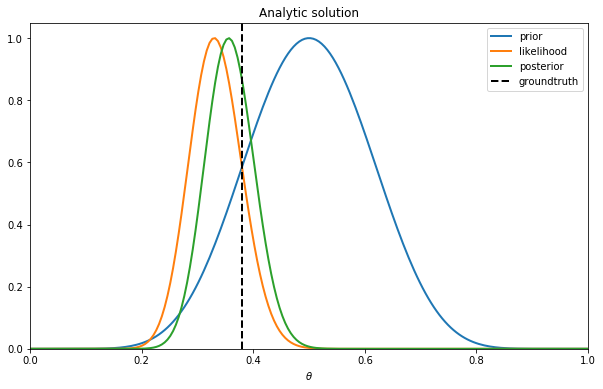

In [5]:
thetas = np.linspace(0, 1, 200)
plt.figure(figsize=(10,6))
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel("$\\theta$")
plt.plot(thetas, prior.pdf(thetas)/prior.pdf(thetas).max(), label="prior")
plt.plot(thetas, lh(Ntrials,thetas).pmf(Nsuccesses)/lh(Ntrials,thetas).pmf(Nsuccesses).max(), label="likelihood")
plt.plot(thetas, posterior.pdf(thetas)/posterior.pdf(thetas).max(), label="posterior")
plt.plot([groundtruth,groundtruth],[0,1.05],color='black',linestyle='--',label="groundtruth")
plt.title("Analytic solution")
plt.legend(loc='best')
plt.show()

## Metropolis-Hastings sampler

In [6]:
def proposal_pdf(sigma):
    return norm(0,sigma)

In [7]:
def MH_sampler(Ntries,theta_start,Ntrials,Nsuccesses,lh,prior,proposal_sigma):
    Naccepted=0
    samples=np.zeros(Ntries+1)
    samples[0]=theta_start
    theta=theta_start
    for i in range(Ntries):
        theta_p = theta + proposal_pdf(proposal_sigma).rvs()
        # the Gaussian proposal pdf satisfies the detailed balance equation, so the
        # acceptance ratio simplifies to the Metropolis ratio
        a = min(1, target_pdf(theta_p,Ntrials,Nsuccesses,lh,prior)/target_pdf(theta,Ntrials,Nsuccesses,lh,prior))
        u = np.random.uniform()
        if u < a:
            Naccepted+=1
            theta=theta_p
        samples[i+1] = theta
    return Naccepted, samples

In [8]:
Ntries1=10000
Nburnin=1000
proposal_sigma=0.1
theta_start=0.6
Naccepted, samples = MH_sampler(Ntries1,theta_start,Ntrials,Nsuccesses,lh,prior,proposal_sigma)
fraction_accepted=float(Naccepted)/Ntries1

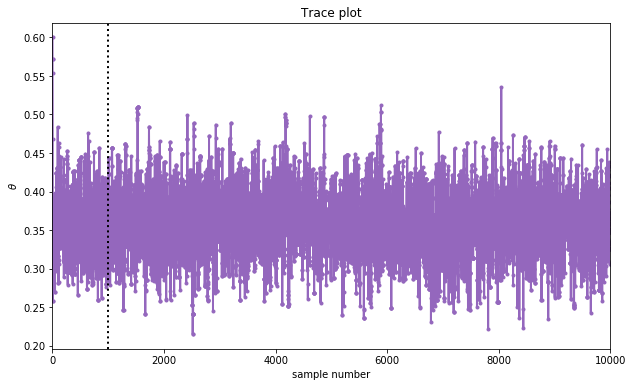

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlim(0,Ntries1)
ax.set_xlabel("sample number")
ax.set_title("Trace plot")
ax.set_ylabel("$\\theta$")
ax.plot(np.arange(Ntries1+1),samples,marker='.',color='C4')
ymin, ymax = ax.get_ylim()
ax.set_ylim([ymin,ymax])
ax.plot([Nburnin,Nburnin],[ymin,ymax],color='black',linestyle=':')
plt.show()

In [10]:
fraction_accepted

0.4524

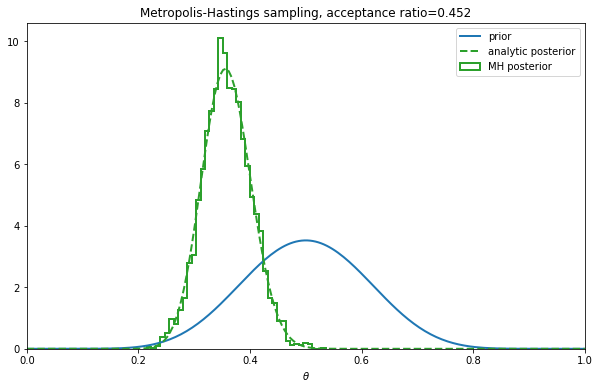

In [11]:
burnedin_samples=samples[Nburnin:]
plt.figure(figsize=(10,6))
plt.xlim([0,1])
plt.xlabel("$\\theta$")
plt.plot(thetas, prior.pdf(thetas), label="prior")
plt.hist(burnedin_samples, 40, histtype='step', density=True, color='C2', linewidth=2, label="MH posterior")
plt.plot(thetas, posterior.pdf(thetas), color='C2', linestyle='--', label="analytic posterior")
plt.title("Metropolis-Hastings sampling, acceptance ratio={:.3f}".format(fraction_accepted))
plt.legend(loc='best')
plt.show()

## Markov Chain diagnostics

### 1- Step size

In [12]:
Ntries2=1000
theta_start=0.6

In [13]:
# Suitable step size
proposal_sigma_1=0.1
Naccepted_1, samples_1 = MH_sampler(Ntries2,theta_start,Ntrials,Nsuccesses,lh,prior,proposal_sigma_1)
fraction_accepted_1=float(Naccepted_1)/Ntries2

In [14]:
# Step size too large
proposal_sigma_2=4
Naccepted_2, samples_2 = MH_sampler(Ntries2,theta_start,Ntrials,Nsuccesses,lh,prior,proposal_sigma_2)
fraction_accepted_2=float(Naccepted_2)/Ntries2

In [15]:
# Step size too small
proposal_sigma_3=0.003
Naccepted_3, samples_3 = MH_sampler(Ntries2,theta_start,Ntrials,Nsuccesses,lh,prior,proposal_sigma_3)
fraction_accepted_3=float(Naccepted_3)/Ntries2

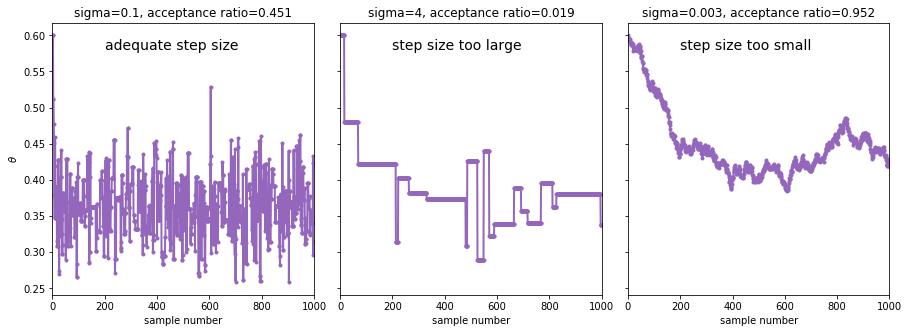

In [16]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))
ax1.set_xlim(0,Ntries2)
ax1.set_xlabel("sample number")
ax1.set_ylabel("$\\theta$")
ax1.plot(np.arange(Ntries2+1),samples_1,marker='.',color='C4')
ax1.set_title("sigma={}, acceptance ratio={:.3f}".format(proposal_sigma_1,fraction_accepted_1))
ax2.set_xlim(0,Ntries2)
ax2.set_xlabel("sample number")
ax2.plot(np.arange(Ntries2+1),samples_2,marker='.',color='C4')
ax2.set_title("sigma={}, acceptance ratio={:.3f}".format(proposal_sigma_2,fraction_accepted_2))
ax3.set_xlim(0,Ntries2)
ax3.set_xlabel("sample number")
ax3.plot(np.arange(Ntries2+1),samples_3,marker='.',color='C4')
ax3.set_title("sigma={}, acceptance ratio={:.3f}".format(proposal_sigma_3,fraction_accepted_3))
ymin, ymax = ax1.get_ylim()
ax1.text(200,ymax-(ymax-ymin)/10., "adequate step size",fontsize=14)
ax2.text(200,ymax-(ymax-ymin)/10., "step size too large",fontsize=14)
ax3.text(200,ymax-(ymax-ymin)/10., "step size too small",fontsize=14)
f.subplots_adjust(wspace=0.1)
plt.show()

### 2- Multiple chains, different starting point

In [17]:
Ntries3=100
proposal_sigma=0.05
Nchains=5

In [18]:
# Run Nchains different chains starting at different positions in parameter space
chains = [MH_sampler(Ntries3,theta_start,Ntrials,Nsuccesses,lh,prior,proposal_sigma)
          for theta_start in np.linspace(0.1,0.9,Nchains)]

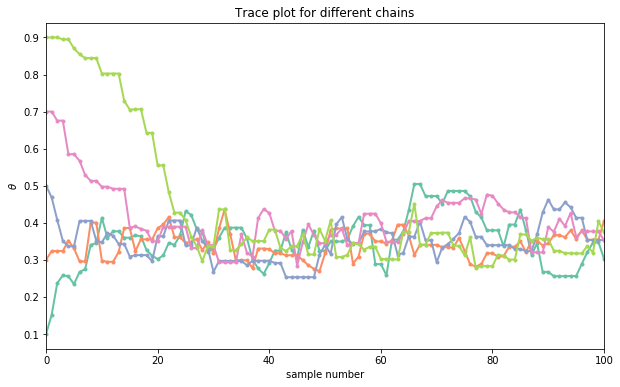

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlim(0,Ntries3)
ax.set_xlabel("sample number")
ax.set_ylabel("$\\theta$")
ax.set_prop_cycle(cycler('color', [plt.cm.Set2(i) for i in np.linspace(0, 1., 8)]))
for samples in chains:
    ax.plot(np.arange(Ntries3+1),samples[1],marker='.')
plt.title("Trace plot for different chains")
plt.show()

### 3- Gelman-Rubin test

Gelman *et al.*, "*Bayesian Data Analysis*" (third edition), p. 284-285

**Parameters**:
* $m$: number of chains
* $n$: length of chains

**Definitions**:
* "between" chains variance:
\begin{equation}
B \equiv \frac{n}{m-1} \sum_{j=1}^m \left( \bar{\psi}_{. j} - \bar{\psi}_{..} \right)^2 \quad \mathrm{where} \quad \bar{\psi}_{. j} = \frac{1}{n} \sum_{i=1}^n \psi_{ij} \quad \mathrm{and} \quad \bar{\psi}_{..} = \frac{1}{m} \sum_{j=1}^m \bar{\psi}_{.j}
\end{equation}
* "within" chains variance:
\begin{equation}
W \equiv \frac{1}{m} \sum_{j=1}^m s_j^2 \quad \mathrm{where} \quad s_j^2 = \frac{1}{n-1} \sum_{i=1}^n \left( \psi_{ij} - \bar{\psi}_{.j} \right)^2
\end{equation}

**Estimators**:
Estimators of the marginal posterior variance of the estimand:
* $\widehat{\mathrm{var}}^- \equiv W$: underestimates the variance
* $\widehat{\mathrm{var}}^+ \equiv \frac{n}{n-1}W + \frac{1}{n} B$: overestimates the variance

**Test**:
* Potential scale reduction factor: $\widehat{R} \equiv \sqrt{\frac{\widehat{\mathrm{var}}^+}{\widehat{\mathrm{var}}^-}}$
* Test: $\widehat{R} \rightarrow 1$ as $n \rightarrow \infty$

In [20]:
psi_j = np.array([np.mean(chains[j][1]) for j in range(Nchains)])
psi = np.mean(psi_j)
B = float(Nchains)/(Ntries3-1)*np.sum((psi_j-psi*np.ones(Nchains))**2)
B

0.00040276881731590047

In [21]:
s_j = np.array([1./(Ntries3-1)*np.sum((chains[j][1]-psi_j[j])**2) for j in range(Nchains)])
W = np.mean(s_j)
W

0.01067472484604469

In [22]:
var_minus=W
var_plus=float(Ntries3)/(Ntries3-1)*W+1./Ntries3*B
var_minus, var_plus

(0.01067472484604469, 0.01078657803771325)

In [23]:
R=np.sqrt(var_plus/var_minus)
R

1.0052255074490637